# **Chrun Prediction **

This file will cover data smoting, MLP and decision tree along with thier hybrid and ensemble approaches:

- [Loading & smote](#loading)
- [Model fitting](#model)
    - [decision tree](#dt)
    - [MLP](#MLP)
    - [DRNN](#rnn)
    - [XGB](#xgb)
    - [Random Forest](#rf)
- [hybrid](#hy)
- [validation](#val)

### imports

In [1]:
#imports
import pandas as pd
# from torch.utils.data
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from skorch import NeuralNetBinaryClassifier
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostRegressor
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns # For creating plots
import matplotlib.ticker as mtick # For specifying the axes tick format
import matplotlib.pyplot as plt
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import NearMiss
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns #Visualization
import plotly.express as px
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import collections


# Other Libraries
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report,roc_curve
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")


<a id='loading'></a>
### loading

In [2]:
df_train = pd.read_csv("train_set_final.csv")
df_test = pd.read_csv("test_set_final.csv")
y_train_clean = df_train['STATUS']
X_train_clean = df_train.drop(['STATUS'], axis=1)
# X_train1 = X_train1[col]

y_test_clean = df_test['STATUS']
X_test_clean = df_test.drop(['STATUS'], axis=1)



In [3]:
df_train = pd.read_csv("train_resampled.csv")
df_test = pd.read_csv("test_resampled.csv")

y_train_sm = df_train['STATUS']
X_train_sm = df_train.drop(['STATUS'], axis=1)

y_test_sm = df_test['STATUS']
X_test_sm = df_test.drop(['STATUS'], axis=1)


In [14]:
X_test_sm_c = X_test_sm.copy()
X_train_sm_c = X_train_sm.copy()


scale = StandardScaler()
scale.fit(X_train_sm_c)

scale_t = StandardScaler()
scale_t.fit(X_test_sm_c)

sc_train =scale.transform(X_train_sm_c)
sc_test =scale_t.transform(X_test_sm_c)

In [15]:
X_test_c = X_test_clean.copy()
X_train_c = X_train_clean.copy()


scale = StandardScaler()
scale.fit(X_train_c)

scale_t = StandardScaler()
scale_t.fit(X_test_c)

sc_train_clean = scale.transform(X_train_c)
sc_test_clean = scale_t.transform(X_test_c)

data copying and scaling for MLP

In [6]:
def model_val(labels_test,pred, pred_proba):
    cnf_matrix=confusion_matrix(labels_test,pred)
    print("AUC",roc_auc_score(labels_test, pred_proba))
    print("the recall for this model is :",cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[1,0]))
    print("TP",cnf_matrix[1,1,]) # no of fraud transaction which are predicted fraud
    print("TN",cnf_matrix[0,0]) # no. of normal transaction which are predited normal
    print("FP",cnf_matrix[0,1]) # no of normal transaction which are predicted fraud
    print("FN",cnf_matrix[1,0]) # no of fraud Transaction which are predicted normal

    print("\n----------Classification Report------------------------------------")
    print(classification_report(labels_test,pred, digits=5))
    print(classification_report_imbalanced(labels_test, pred, digits=5))

In [7]:
def roc_png(proba,y, name):
    fpr, tpr, thresholds = roc_curve(y, proba)

    auc = roc_auc_score(y, proba)

    sns.set_style("whitegrid")

    fig, ax = plt.subplots(figsize=(8, 6))

    ax.plot(fpr, tpr, color='darkorange', lw=2)
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='ِAUC = %0.4f' % auc)

    ax.set_xlim([-0.1, 1.0])
    ax.set_ylim([-0.1, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=14)
    ax.set_ylabel('True Positive Rate', fontsize=14)

    # Add a title and legend
    ax.set_title(name, fontsize=18, fontweight='bold')
    ax.legend(loc="lower right", fontsize=12)

    # Customize the tick labels and grid
    ax.tick_params(axis='both', which='major', labelsize=12, length=6, width=2)
    ax.grid(color='lightgray', linestyle='--')

    # Remove the top and right spines
    sns.despine()

    # Save the plot to a file with high resolution
    fig.savefig(name + '.png', dpi=1200, bbox_inches='tight')

    # Show the plot
    plt.show()

In [8]:
def  CrossValidation(model,X,y,K):
    
    # Define the scoring metrics
    scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score, average='weighted'),
               'recall': make_scorer(recall_score, average='weighted'),
               'f1_score': make_scorer(f1_score, average='weighted')}

    cv_results = cross_validate(model, X, y, cv=K, scoring=scoring)

   

   # Print the results
    for metric, values in cv_results.items():
        print(f"{metric}: {values.mean():.5f} (+/- {values.std() * 2:.4f})")

In [9]:
def model(model,features_train,features_test,labels_train,labels_test):
    clf= model
    
    clf.fit(features_train,labels_train)
    
    pred=clf.predict(features_test)
    
    pred_proba=clf.predict_proba(features_test)
    
    print("AUC",roc_auc_score(labels_test, pred_proba[:,1]))
    
    
    cnf_matrix=confusion_matrix(labels_test,pred)
    
   
    print("TP",cnf_matrix[1,1,]) # no of fraud transaction which are predicted fraud
    print("TN",cnf_matrix[0,0]) # no. of normal transaction which are predited normal
    print("FP",cnf_matrix[0,1]) # no of normal transaction which are predicted fraud
    print("FN",cnf_matrix[1,0]) # no of fraud Transaction which are predicted normal from sklearn.metrics import f1_score
    
    
    print("\n----------Classification Report------------------------------------")
    print(classification_report(labels_test,pred,digits=5))
    return pred_proba, pred

<a id='model'></a>
# **Model fiting**

<a id='dt'></a>


## 1.1 Decision Tree Classifier

The Decision Tree classifier is a popular machine learning algorithm that uses a tree-like model of decisions and their possible consequences. Each internal node represents a feature or attribute, each branch represents a decision rule, and each leaf node represents an outcome. The Decision Tree Classifier is used for this particular task.

### Model Hyperparameters

The Decision Tree classifier used for this task was configured with the following hyperparameters:

| Hyperparameter | Value                         | Description                                                      |
|----------------|-------------------------------|------------------------------------------------------------------|
| ccp_alpha      | 1.5151515151515151e-05        | Complexity parameter used for pruning the decision tree.         |
| random_state   | 1                             | Seed value for random number generation to ensure reproducibility. |



These hyperparameters were chosen based on experimentation and may require further tuning for optimal performance on specific data.



### balanced

In [ ]:
model_dt = DecisionTreeClassifier(ccp_alpha =  1.5151515151515151e-05 , random_state=1)
model_dt.fit(X_train_sm, y_train_sm)

DecisionTreeClassifier(ccp_alpha=1.5151515151515151e-05, random_state=1)

In [ ]:
y_pred_nor = model_dt.predict(X_test_sm)
probas_nor= model_dt.predict_proba(X_test_sm)
model_val(y_test_sm, y_pred_nor, probas_nor[:,1])

AUC 0.9261147149174054
the recall for this model is : 0.9341469616069158
TP 51436
TN 38584
FP 5928
FN 3626

----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0    0.91410   0.86682   0.88983     44512
           1    0.89666   0.93415   0.91502     55062

    accuracy                        0.90405     99574
   macro avg    0.90538   0.90048   0.90243     99574
weighted avg    0.90445   0.90405   0.90376     99574

                   pre       rec       spe        f1       geo       iba       sup

          0    0.91410   0.86682   0.93415   0.88983   0.89986   0.80429     44512
          1    0.89666   0.93415   0.86682   0.91502   0.89986   0.81519     55062

avg / total    0.90445   0.90405   0.89692   0.90376   0.89986   0.81032     99574



In [ ]:
y_pred_train = model_dt.predict(X_train_sm)
y_proba_train = model_dt.predict_proba(X_train_sm)
model_val(y_train_sm, y_pred_train,y_proba_train[:,1])

AUC 0.9906271812669769
the recall for this model is : 0.9811666848280121
TP 108050
TN 93054
FP 3446
FN 2074

----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0    0.97820   0.96429   0.97119     96500
           1    0.96909   0.98117   0.97509    110124

    accuracy                        0.97328    206624
   macro avg    0.97365   0.97273   0.97314    206624
weighted avg    0.97335   0.97328   0.97327    206624

                   pre       rec       spe        f1       geo       iba       sup

          0    0.97820   0.96429   0.98117   0.97119   0.97269   0.94453     96500
          1    0.96909   0.98117   0.96429   0.97509   0.97269   0.94773    110124

avg / total    0.97335   0.97328   0.97217   0.97327   0.97269   0.94623    206624



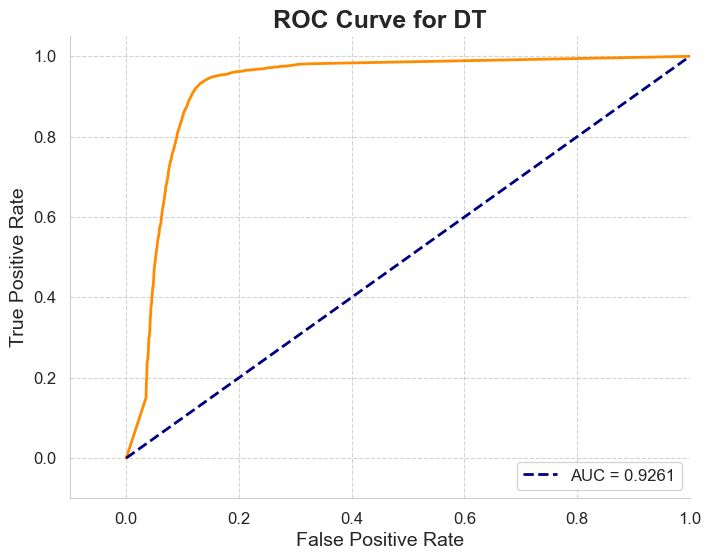

In [ ]:
roc_png(proba =probas_nor[:,1],y=y_test_sm, name = 'ROC Curve for DT')

**Dt with prune results:**
- Test Accuracy = 90.405%.
- Test F1-score = 90.243%.
- Test Precision = 90.538%.

### unbalanced

In [14]:
model_dt_clean = DecisionTreeClassifier(ccp_alpha =  1.5151515151515151e-05 , random_state=1)
model_dt_clean.fit(X_train_clean, y_train_clean)


y_pred_nor_clean = model_dt_clean.predict(X_test_clean)
probas_nor_clean = model_dt_clean.predict_proba(X_test_clean)
model_val(y_test_clean, y_pred_nor_clean, probas_nor_clean[:,1])

AUC 0.7539959190561712
the recall for this model is : 0.9783879989829647
TP 53872
TN 1290
FP 1672
FN 1190

----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0    0.52016   0.43552   0.47409      2962
           1    0.96990   0.97839   0.97412     55062

    accuracy                        0.95068     58024
   macro avg    0.74503   0.70695   0.72411     58024
weighted avg    0.94694   0.95068   0.94860     58024

                   pre       rec       spe        f1       geo       iba       sup

          0    0.52016   0.43552   0.97839   0.47409   0.65277   0.40297      2962
          1    0.96990   0.97839   0.43552   0.97412   0.65277   0.44924     55062

avg / total    0.94694   0.95068   0.46323   0.94860   0.65277   0.44687     58024



**unbalanced Dt with prune results:**
- Test Accuracy = 95.068%.
- Test F1-score = 72.411%.
- Test Precision = 74.503%.

## Optimal Dt 1.2
(with ada, bagging and prune)

### balanced

In [ ]:
model_ada = BalancedBaggingClassifier(
AdaBoostClassifier(DecisionTreeClassifier(ccp_alpha =3.49297098164335e-04 , random_state=1),
                           random_state=1,n_estimators=120), n_jobs=-1,random_state=1)
model_ada.fit(X_train_sm, y_train_sm)

BalancedBaggingClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(ccp_alpha=0.000349297098164335,
                                                                                        random_state=1),
                                                       n_estimators=120,
                                                       random_state=1),
                          n_jobs=-1, random_state=1)

In [ ]:

y_pred_ada = model_ada.predict(X_test_sm)
probas_ada=model_ada.predict_proba(X_test_sm)
model_val(y_test_sm, y_pred_ada, probas_ada[:,1])

AUC 0.9934335805815762
the recall for this model is : 0.9870872834259562
TP 54351
TN 41321
FP 3191
FN 711

----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0    0.98308   0.92831   0.95491     44512
           1    0.94454   0.98709   0.96535     55062

    accuracy                        0.96081     99574
   macro avg    0.96381   0.95770   0.96013     99574
weighted avg    0.96177   0.96081   0.96068     99574

                   pre       rec       spe        f1       geo       iba       sup

          0    0.98308   0.92831   0.98709   0.95491   0.95725   0.91094     44512
          1    0.94454   0.98709   0.92831   0.96535   0.95725   0.92171     55062

avg / total    0.96177   0.96081   0.95459   0.96068   0.95725   0.91690     99574



In [ ]:
y_pred_train_bb = model_ada.predict(X_train_sm)
probas_=model_ada.predict_proba(X_test_sm)
model_val(y_test_sm, y_pred_ada, probas_[:,1])

AUC 0.9934335805815762
the recall for this model is : 0.9870872834259562
TP 54351
TN 41321
FP 3191
FN 711

----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0    0.98308   0.92831   0.95491     44512
           1    0.94454   0.98709   0.96535     55062

    accuracy                        0.96081     99574
   macro avg    0.96381   0.95770   0.96013     99574
weighted avg    0.96177   0.96081   0.96068     99574

                   pre       rec       spe        f1       geo       iba       sup

          0    0.98308   0.92831   0.98709   0.95491   0.95725   0.91094     44512
          1    0.94454   0.98709   0.92831   0.96535   0.95725   0.92171     55062

avg / total    0.96177   0.96081   0.95459   0.96068   0.95725   0.91690     99574



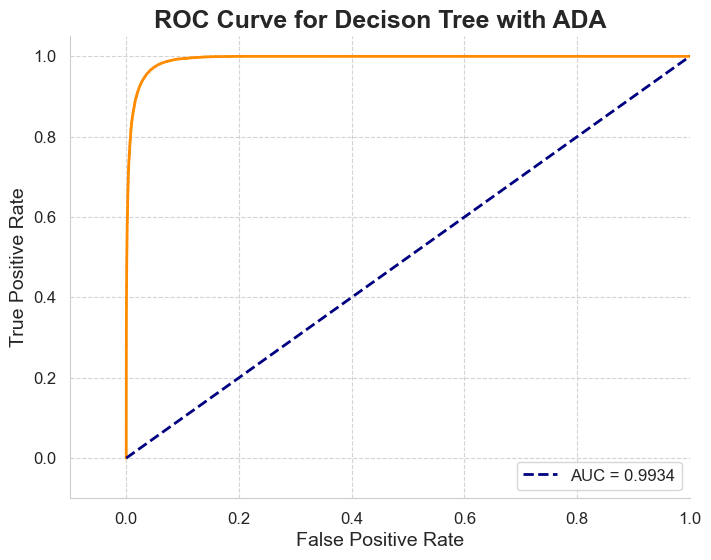

In [ ]:
roc_png(proba =probas_ada,y=y_test_sm, name = 'ROC Curve for Decison Tree with ADA')

**optimal dt results:**
- Test Accuracy = 96.081%.
- Test F1-score = 96.013%.
- Test Precision = 96.381%.

### unbalanced

In [ ]:
model_ada_clean = BalancedBaggingClassifier(
AdaBoostClassifier(DecisionTreeClassifier(ccp_alpha =3.49297098164335e-04 , random_state=1),
                           random_state=1,n_estimators=120), n_jobs=-1,random_state=1)

model_ada_clean.fit(X_train_clean, y_train_clean)


y_pred_ada_clean = model_ada_clean.predict(X_test_clean)
probas_ada_clean = model_ada_clean.predict_proba(X_test_clean)
model_val(y_test_clean, y_pred_ada_clean, probas_ada_clean[:,1])

AUC 0.9042727869885598
the recall for this model is : 0.9014202172096909
TP 49634
TN 2007
FP 955
FN 5428

----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0    0.26994   0.67758   0.38607      2962
           1    0.98112   0.90142   0.93958     55062

    accuracy                        0.88999     58024
   macro avg    0.62553   0.78950   0.66283     58024
weighted avg    0.94482   0.88999   0.91133     58024

                   pre       rec       spe        f1       geo       iba       sup

          0    0.26994   0.67758   0.90142   0.38607   0.78153   0.59712      2962
          1    0.98112   0.90142   0.67758   0.93958   0.78153   0.62446     55062

avg / total    0.94482   0.88999   0.68901   0.91133   0.78153   0.62306     58024



**unbalanced optimal dt results:**
- Test Accuracy = 88.276%.
- Test F1-score = 62.402%.
- Test Precision = 66.139%.

<a id='MLP'></a>
## 1.3 Multi-Layer Perceptron (MLP) Classifier

The Multi-Layer Perceptron (MLP) classifier is a type of artificial neural network that is widely used for classification tasks. It consists of multiple layers of interconnected neurons and uses backpropagation to optimize the weights. The MLPClassifier is used for this particular task.

### Model Hyperparameters

The MLP classifier used for this task was configured with the following hyperparameters:

| Hyperparameter       | Value     | Description                                                |
|---------------------|-----------|------------------------------------------------------------|
| solver              | adam      | The solver algorithm for weight optimization.               |
| activation          | relu      | The activation function for hidden layers.                  |
| hidden_layer_sizes  | 120       | The number of neurons in the hidden layers.                 |
| random_state        | 1         | Seed value for random number generation.                    |

These hyperparameters were chosen based on experimentation and domain knowledge to achieve the best performance for the given task.



### balanced

In [ ]:
model_MLP =  MLPClassifier(solver='adam', activation= 'relu', hidden_layer_sizes=120, random_state=1 )
#BalancedBaggingClassifier(MLPClassifier(solver='adam', activation= 'relu', hidden_layer_sizes=120, random_state=1 ), n_jobs=-1,random_state=1)
model_MLP.fit(sc_train, y_train_sm)

MLPClassifier(hidden_layer_sizes=120, random_state=1)

In [ ]:
#0.95314   0.95167   0.94394   0.95146   0.94710   0.89769     99550
y_pred = model_MLP.predict(sc_test)
probas_MLP=model_MLP.predict_proba(sc_test)
model_val(y_test_sm, y_pred, probas_MLP[:,1])

AUC 0.9801583062362406
the recall for this model is : 0.9462242562929062
TP 52101
TN 41216
FP 3296
FN 2961

----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0    0.93297   0.92595   0.92945     44512
           1    0.94050   0.94622   0.94335     55062

    accuracy                        0.93716     99574
   macro avg    0.93674   0.93609   0.93640     99574
weighted avg    0.93714   0.93716   0.93714     99574

                   pre       rec       spe        f1       geo       iba       sup

          0    0.93297   0.92595   0.94622   0.92945   0.93603   0.87438     44512
          1    0.94050   0.94622   0.92595   0.94335   0.93603   0.87793     55062

avg / total    0.93714   0.93716   0.93501   0.93714   0.93603   0.87635     99574



In [ ]:
#0.96789   0.96744   0.96495   0.96739   0.96601   0.93341
y_pred_train_cc = model_MLP.predict(sc_train)
probas_tr=model_MLP.predict_proba(sc_train)
model_val(y_train_sm, y_pred_train_cc,probas_tr[:,1])

AUC 0.989310675784603
the recall for this model is : 0.9489121354109913
TP 104498
TN 91492
FP 5008
FN 5626

----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0    0.94207   0.94810   0.94508     96500
           1    0.95427   0.94891   0.95158    110124

    accuracy                        0.94853    206624
   macro avg    0.94817   0.94851   0.94833    206624
weighted avg    0.94857   0.94853   0.94854    206624

                   pre       rec       spe        f1       geo       iba       sup

          0    0.94207   0.94810   0.94891   0.94508   0.94851   0.89959     96500
          1    0.95427   0.94891   0.94810   0.95158   0.94851   0.89974    110124

avg / total    0.94857   0.94853   0.94848   0.94854   0.94851   0.89967    206624



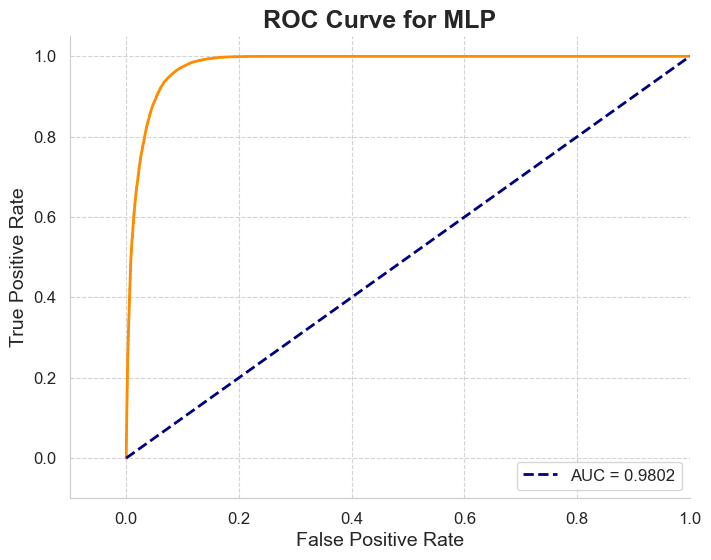

In [ ]:
roc_png(proba =probas_MLP,y=y_test_sm, name = 'ROC Curve for MLP')

**MLP results:**
- Test Accuracy = 95.295%.
- Test F1-score = 95.215%.
- Test Precision = 95.546%.

### unbalanced

In [ ]:
model_MLP_clean =  MLPClassifier(solver='adam', activation= 'relu', hidden_layer_sizes=120, random_state=1 )
#BalancedBaggingClassifier(MLPClassifier(solver='adam', activation= 'relu', hidden_layer_sizes=120, random_state=1 ), n_jobs=-1,random_state=1)
model_MLP_clean.fit(sc_train_clean, y_train_clean)


y_pred_mlp_clean = model_MLP_clean.predict(sc_test_clean)
probas_mlp_clean = model_MLP_clean.predict_proba(sc_test_clean)
model_val(y_test_clean, y_pred_mlp_clean, probas_mlp_clean[:,1])

AUC 0.8341952246771799
the recall for this model is : 0.9921361374450619
TP 54629
TN 463
FP 2499
FN 433

----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0    0.51674   0.15631   0.24002      2962
           1    0.95626   0.99214   0.97387     55062

    accuracy                        0.94947     58024
   macro avg    0.73650   0.57422   0.60694     58024
weighted avg    0.93382   0.94947   0.93640     58024

                   pre       rec       spe        f1       geo       iba       sup

          0    0.51674   0.15631   0.99214   0.24002   0.39381   0.14212      2962
          1    0.95626   0.99214   0.15631   0.97387   0.39381   0.16805     55062

avg / total    0.93382   0.94947   0.19898   0.93640   0.39381   0.16672     58024



**unbalanced MLP results:**
- Test Accuracy = 91.576%.
- Test F1-score = 68.244%.
- Test Precision = 64.762%.

<a id='rnn'></a>
## DRNN 1.4

In [ ]:
class Rnn_model(nn.Module): #best perofmer is rnn + 2 fc prelu + classifier layer 100 hiddenshape
    def __init__(self, input_shape:int, hidden_shape:int, output_shape:int):
        super(Rnn_model,self).__init__()
        self.next_shape = hidden_shape*2
        self.rnn =nn.RNN(input_shape, hidden_shape, batch_first=True)


        self.con2 = nn.Sequential(

            nn.Linear(in_features=hidden_shape,out_features=hidden_shape),
            nn.PReLU(),)

        self.classifer = nn.Sequential(
            nn.Linear(in_features=self.next_shape*2,out_features=self.next_shape*2),
            nn.PReLU(),
            nn.Linear(in_features=self.next_shape*2,out_features=self.next_shape),
            nn.PReLU(),
            nn.Linear(in_features=self.next_shape,out_features=hidden_shape),
            nn.PReLU(),
)
        self.classifer2 = nn.Linear(in_features=hidden_shape ,out_features=output_shape)

    def forward(self,x):
        z, a = self.rnn(x)
        z = z.contiguous().view(-1, self.next_shape//2)
        z = self.con2(z)
        z = self.classifer2(z)
        return z

In [ ]:
import skorch
class NeuralNetBinaryClassifier(skorch.NeuralNetBinaryClassifier):
    def fit(self, X, y, **fit_params):
        return super().fit(X, np.asarray(y, dtype=np.float32), **fit_params)

### balanced

In [ ]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)
model_rnn= NeuralNetBinaryClassifier(Rnn_model(53,100,1),
    criterion=torch.nn.BCEWithLogitsLoss,
    optimizer=torch.optim.Adam,
    lr=0.001,
    max_epochs=4,
    batch_size=700,
    verbose=False

)
X_train_ = torch.tensor(sc_train,dtype=torch.float32)
y_train_ = torch.tensor(y_train_sm,dtype=torch.float32)
model_rnn.fit(X_train_, y_train_)



<class '__main__.NeuralNetBinaryClassifier'>[initialized](
  module_=Rnn_model(
    (rnn): RNN(53, 100, batch_first=True)
    (con2): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): PReLU(num_parameters=1)
    )
    (classifer): Sequential(
      (0): Linear(in_features=400, out_features=400, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=400, out_features=200, bias=True)
      (3): PReLU(num_parameters=1)
      (4): Linear(in_features=200, out_features=100, bias=True)
      (5): PReLU(num_parameters=1)
    )
    (classifer2): Linear(in_features=100, out_features=1, bias=True)
  ),
)

In [ ]:
X_test_ = torch.tensor(sc_test,dtype=torch.float32)
y_test_ = torch.tensor(y_test_sm,dtype=torch.float32)

y_pred_rnn = model_rnn.predict(X_test_)
probas_rnn = model_rnn.predict_proba(X_test_)
model_val(y_test_, y_pred_rnn, probas_rnn[:,1])

AUC 0.9737716403577187
the recall for this model is : 0.9990192873488069
TP 55008
TN 41527
FP 2985
FN 54

----------Classification Report------------------------------------
              precision    recall  f1-score   support

         0.0    0.99870   0.93294   0.96470     44512
         1.0    0.94853   0.99902   0.97312     55062

    accuracy                        0.96948     99574
   macro avg    0.97361   0.96598   0.96891     99574
weighted avg    0.97096   0.96948   0.96936     99574

                   pre       rec       spe        f1       geo       iba       sup

        0.0    0.99870   0.93294   0.99902   0.96470   0.96541   0.92587     44512
        1.0    0.94853   0.99902   0.93294   0.97312   0.96541   0.93818     55062

avg / total    0.97096   0.96948   0.96248   0.96936   0.96541   0.93268     99574



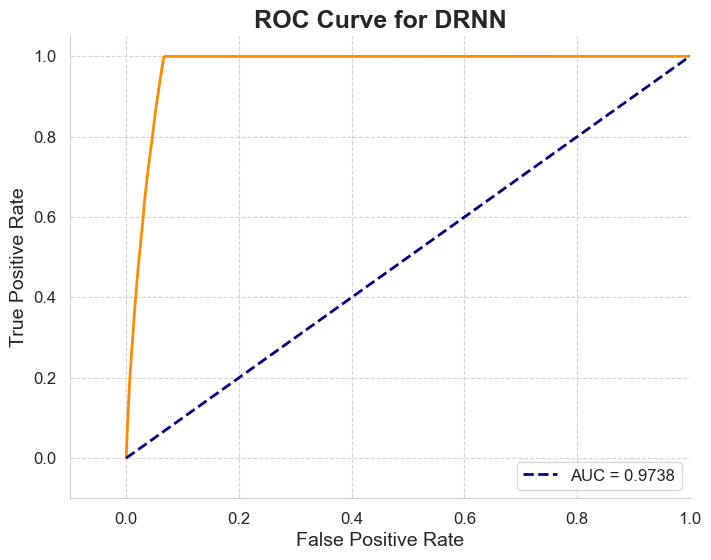

In [ ]:
roc_png(proba =probas_rnn,y=y_test_sm, name = 'ROC Curve for DRNN')

**DRNN results:**
- Test Accuracy = 96.948%.
- Test F1-score = 96.891%.
- Test Precision = 97.361%.

### unbalanced

In [ ]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)
model_rnn_clean= NeuralNetBinaryClassifier(Rnn_model(53,100,1),
    criterion=torch.nn.BCEWithLogitsLoss,
    optimizer=torch.optim.Adam,
    lr=0.001,
    max_epochs=4,
    batch_size=700,
    verbose=False

)
X_train_clean = torch.tensor(sc_train_clean,dtype=torch.float32)
y_train_clean = torch.tensor(y_train_clean,dtype=torch.float32)
model_rnn_clean.fit(X_train_clean, y_train_clean)

<class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=Rnn_model(
    (rnn): RNN(53, 100, batch_first=True)
    (con2): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): PReLU(num_parameters=1)
    )
    (classifer): Sequential(
      (0): Linear(in_features=400, out_features=400, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=400, out_features=200, bias=True)
      (3): PReLU(num_parameters=1)
      (4): Linear(in_features=200, out_features=100, bias=True)
      (5): PReLU(num_parameters=1)
    )
    (classifer2): Linear(in_features=100, out_features=1, bias=True)
  ),
)

In [ ]:
X_test_clean = torch.tensor(sc_test_clean,dtype=torch.float32)
y_test_clean = torch.tensor(y_test_clean,dtype=torch.float32)

y_pred_rnn_clean = model_rnn_clean.predict(X_test_clean)
probas_rnn_clean = model_rnn_clean.predict_proba(X_test_clean)
model_val(y_test_clean, y_pred_rnn_clean, probas_rnn_clean[:,1])

AUC 0.7255950084725558
the recall for this model is : 0.9998910319276452
TP 55056
TN 0
FP 2962
FN 6

----------Classification Report------------------------------------
              precision    recall  f1-score   support

         0.0    0.00000   0.00000   0.00000      2962
         1.0    0.94895   0.99989   0.97375     55062

    accuracy                        0.94885     58024
   macro avg    0.47447   0.49995   0.48688     58024
weighted avg    0.90051   0.94885   0.92405     58024

                   pre       rec       spe        f1       geo       iba       sup

        0.0    0.00000   0.00000   0.99989   0.00000   0.00000   0.00000      2962
        1.0    0.94895   0.99989   0.00000   0.97375   0.00000   0.00000     55062

avg / total    0.90051   0.94885   0.05104   0.92405   0.00000   0.00000     58024



**unbalanced DRNN results:**
- Test Accuracy = 81.230%.
- Test F1-score = 49.075%.
- Test Precision = 50.369%.

<a id='xgb'></a>

## 1.5 XGBoost Classifier

XGBoost (Extreme Gradient Boosting) is a popular gradient boosting framework that is known for its efficiency and effectiveness in solving machine learning problems. It is based on the gradient boosting algorithm and provides high predictive performance. The XGBoost Classifier is used for this particular task.




### Model Hyperparameters

The XGBoost classifier used for this task was configured with the following hyperparameters:

| Hyperparameter     | Value     | Description                                     |
|-------------------|-----------|-------------------------------------------------|
| n_estimators      | 110       | Number of boosting rounds (decision trees) to build.  |
| max_depth         | 13        | Maximum depth of each decision tree.            |
| learning_rate     | 0.2       | Step size shrinkage used in update to prevent overfitting. |
| objective         | binary:logitraw | The loss function to be minimized during training. |
| max_features      | None      | Maximum number of features to consider for splitting. |
| verbosity         | 0         | Verbosity mode for printing messages during training. |
| use_label_encoder | False     | Whether to use label encoding for target variables. |
| n_jobs            | -1        | Number of parallel threads to use for fitting and predicting. |
| random_state      | 0         | Seed value for random number generation.         |

These hyperparameters were chosen based on experimentation and domain knowledge to achieve the best performance for the given task.





### balanced

In [69]:
xg= xgb.XGBClassifier(n_estimators=110, max_depth=13,
                    learning_rate=0.2,
                    objective='binary:logitraw',
                    max_features=None,
                    verbosity  = 0,

                    use_label_encoder=False,
                    n_jobs=-1,
                   random_state  = 0 )

xg.fit(X_train_sm,y_train_sm)

y_pred_xg= xg.predict(X_test_sm)
probas_xg=xg.predict_proba(X_test_sm)
model_val(y_test_sm, y_pred_xg, probas_xg[:,1])

AUC 0.9963331891947907
the recall for this model is : 0.9851258581235698
TP 54243
TN 42421
FP 2091
FN 819

----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0    0.98106   0.95302   0.96684     44512
           1    0.96288   0.98513   0.97388     55062

    accuracy                        0.97078     99574
   macro avg    0.97197   0.96907   0.97036     99574
weighted avg    0.97101   0.97078   0.97073     99574

                   pre       rec       spe        f1       geo       iba       sup

          0    0.98106   0.95302   0.98513   0.96684   0.96894   0.93583     44512
          1    0.96288   0.98513   0.95302   0.97388   0.96894   0.94186     55062

avg / total    0.97101   0.97078   0.96737   0.97073   0.96894   0.93917     99574



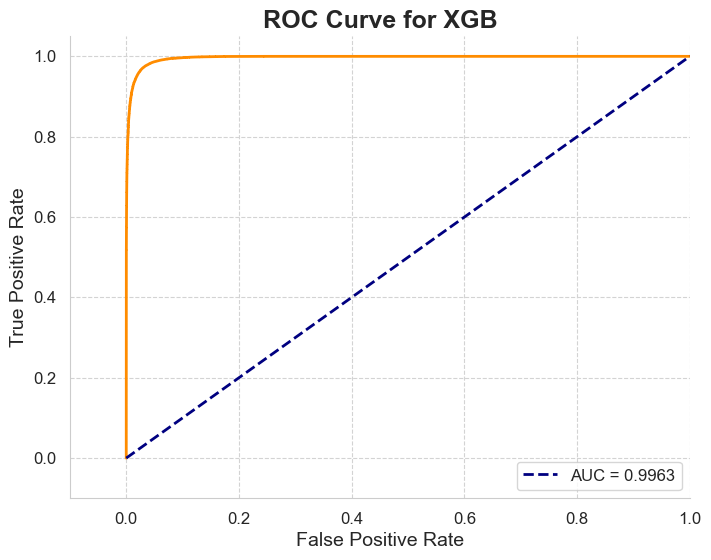

In [71]:
roc_png(proba =probas_xg[:,1] ,y=y_test_sm, name = 'ROC Curve for XGB')

**XGBoost  results:**
- Test Accuracy = 97.078%.
- Test F1-score = 97.036%.
- Test Precision = 97.197%.

### unbalanced

In [70]:
xg_clean = xgb.XGBClassifier(n_estimators=110, max_depth=13,
                    learning_rate=0.2,
                    objective='binary:logitraw',
                    max_features=None,
                    verbosity  = 0,

                    # tree_method = 'gpu_hist',
                    use_label_encoder=False,
                    n_jobs=-1,
                   random_state  = 0 )

xg_clean.fit(X_train_clean,y_train_clean)

y_pred_xg_clean = xg.predict(X_test_clean)
probas_xg_clean = xg.predict_proba(X_test_clean)
model_val(y_test_clean, y_pred_xg_clean, probas_xg_clean[:,1])

AUC 0.9757214879569434
the recall for this model is : 0.9851258581235698
TP 54243
TN 2033
FP 929
FN 819

----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0    0.71283   0.68636   0.69935      2962
           1    0.98316   0.98513   0.98414     55062

    accuracy                        0.96987     58024
   macro avg    0.84800   0.83574   0.84174     58024
weighted avg    0.96936   0.96987   0.96960     58024

                   pre       rec       spe        f1       geo       iba       sup

          0    0.71283   0.68636   0.98513   0.69935   0.82228   0.65595      2962
          1    0.98316   0.98513   0.68636   0.98414   0.82228   0.69635     55062

avg / total    0.96936   0.96987   0.70161   0.96960   0.82228   0.69429     58024



<a id='rf'></a>
## 1.6 Random Forest 
Random Forest is an ensemble learning method that combines multiple decision trees to make predictions. Each decision tree in the ensemble is built on a randomly sampled subset of the training data, and the final prediction is determined by aggregating the predictions of individual trees.


### Model Hyperparameters

The Optimal Random Forest classifier used for this task was configured with the following hyperparameters:

| Hyperparameter     | Value     | Description                                     |
|-------------------|-----------|-------------------------------------------------|
| n_estimators      | 100        | Number of decision trees in the random forest.  |
| max_depth         | 32        | Maximum depth of each decision tree.            |
| min_samples_leaf  | 1         | Minimum number of samples required in a leaf node. |
| max_features      | None      | Maximum number of features to consider for splitting. |
| random_state      | 0         | Seed value for random number generation.         |
| criterion         | entropy   | The function to measure the quality of a split. |
| min_samples_split | 2         | Minimum number of samples required to split an internal node. |
| bootstrap         | True      | Whether to use bootstrap samples when building trees. |
| n_jobs            | -1        | Number of jobs to run in parallel for fitting and predicting. |


### balanced

In [12]:
rf = RandomForestClassifier(n_estimators=17, max_depth=19, min_samples_leaf=1,
                               max_features=None, random_state=0,
                               criterion='entropy', min_samples_split=2,
                               bootstrap=True,n_jobs=-1)

In [13]:
pred_proba, pred = model(rf,X_train_sm,X_test_sm,y_train_sm,y_test_sm)

AUC 0.9842557341608325
TP 53024
TN 40169
FP 4343
FN 2038

----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0    0.95171   0.90243   0.92642     44512
           1    0.92429   0.96299   0.94324     55062

    accuracy                        0.93592     99574
   macro avg    0.93800   0.93271   0.93483     99574
weighted avg    0.93655   0.93592   0.93572     99574



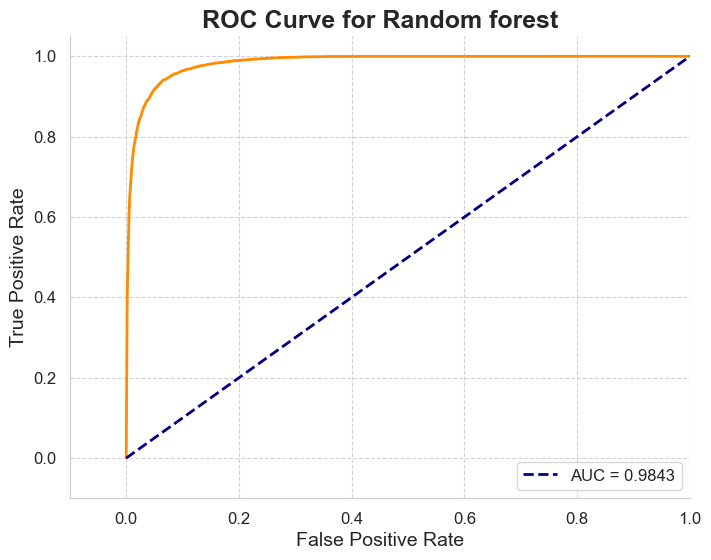

In [68]:
roc_png(proba =pred_proba[:,1] ,y=y_test_sm, name = 'ROC Curve for Random forest')

**Random Forest  results:**
- Test Accuracy = 93.592%.
- Test F1-score = 93.483%.
- Test Precision = 93.800%.

### unbalanced

In [66]:
rf_clean = RandomForestClassifier(n_estimators=17, max_depth=19, min_samples_leaf=1,
                               max_features=None, random_state=0,
                               criterion='entropy', min_samples_split=2,
                               bootstrap=True,n_jobs=-1)

In [67]:
rf_pred_proba_clean, rf_pred_clean = model(rf_clean,X_train_clean,X_test_clean,y_train_clean,y_test_clean)

AUC 0.9529085909687567
TP 55053
TN 432
FP 2530
FN 9

----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0    0.97959   0.14585   0.25389      2962
           1    0.95606   0.99984   0.97746     55062

    accuracy                        0.95624     58024
   macro avg    0.96783   0.57284   0.61568     58024
weighted avg    0.95726   0.95624   0.94052     58024



## 1.7 Optimal Random Forest 

### balanced

In [29]:
rf_op  = BalancedBaggingClassifier(AdaBoostClassifier(
    base_estimator=RandomForestClassifier(n_estimators=100, max_depth=32, min_samples_leaf=1,
                               max_features=None, random_state=0,
                               criterion='entropy', min_samples_split=2,
                               bootstrap=True),),n_jobs=-1)

In [30]:
rf_pred_proba2, rf_pred2 = model(rf_op,X_train_sm,X_test_sm,y_train_sm,y_test_sm)

AUC 0.9908501793847395
TP 53783
TN 40723
FP 3789
FN 1279

----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0    0.96955   0.91488   0.94142     44512
           1    0.93419   0.97677   0.95500     55062

    accuracy                        0.94910     99574
   macro avg    0.95187   0.94582   0.94821     99574
weighted avg    0.94999   0.94910   0.94893     99574

[[1.43405127e-01 8.56594873e-01]
 [1.20727119e-01 8.79272881e-01]
 [1.21167334e-01 8.78832666e-01]
 ...
 [6.96693542e-01 3.03306458e-01]
 [9.99999998e-01 1.90380206e-09]
 [6.85601461e-01 3.14398539e-01]] [1 1 1 ... 0 0 0]


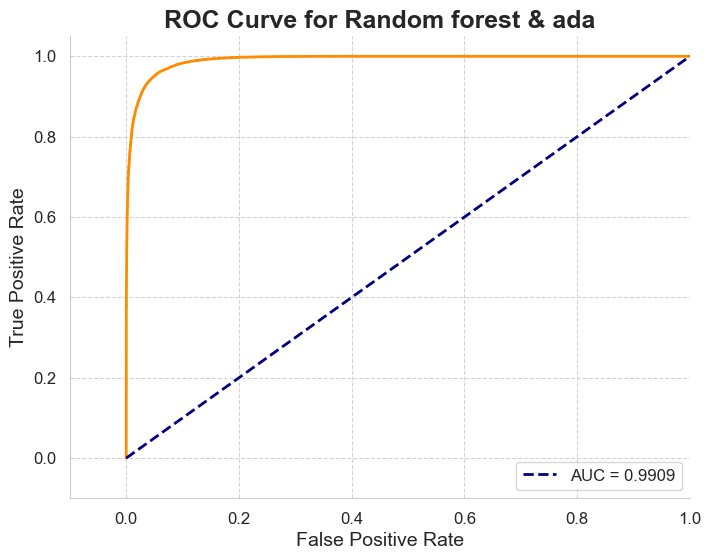

In [32]:
roc_png(proba =rf_pred_proba2[:,1] ,y=y_test_sm, name = 'ROC Curve for Random forest & ada')

**Optimal Random Forest results:**
- Test Accuracy = 94.910%.
- Test F1-score = 95.737%.
- Test Precision = 95.880%.

### unbalanced

In [37]:
rf_op_clean  = BalancedBaggingClassifier(AdaBoostClassifier(
    base_estimator=RandomForestClassifier(n_estimators=100, max_depth=32, min_samples_leaf=1,
                               max_features=None, random_state=0,
                               criterion='entropy', min_samples_split=2,
                               bootstrap=True),),n_jobs=-1)

In [38]:
rf_pred_proba2_clean, rf_pred2_clean = model(rf_op_clean,X_train_clean,X_test_clean,y_train_clean,y_test_clean)

AUC 0.8985513776367643
TP 43992
TN 2413
FP 549
FN 11070

----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0    0.17897   0.81465   0.29346      2962
           1    0.98767   0.79895   0.88335     55062

    accuracy                        0.79976     58024
   macro avg    0.58332   0.80680   0.58840     58024
weighted avg    0.94639   0.79976   0.85323     58024



<a id='hy'></a>
## Hybrid models


## hybrid MLP with Optimal DT 2.1

split = 80% for DT and 20% for MLP

In [ ]:
y_mlp = probas_MLP[:,1]
y_dt = probas_ada[:,1]

y_preds_a = (y_mlp * .2) + (y_dt* .8)

In [ ]:
y_preds = (y_preds_a > .5 ).astype(int)
model_val(y_test_sm, y_preds,y_preds_a)

AUC 0.9878937994307496
the recall for this model is : 0.9556681558969888
TP 52621
TN 41458
FP 3054
FN 2441

----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0    0.94440   0.93139   0.93785     44512
           1    0.94515   0.95567   0.95038     55062

    accuracy                        0.94481     99574
   macro avg    0.94477   0.94353   0.94411     99574
weighted avg    0.94481   0.94481   0.94478     99574

                   pre       rec       spe        f1       geo       iba       sup

          0    0.94440   0.93139   0.95567   0.93785   0.94345   0.88794     44512
          1    0.94515   0.95567   0.93139   0.95038   0.94345   0.89226     55062

avg / total    0.94481   0.94481   0.94224   0.94478   0.94345   0.89033     99574



In [ ]:
y_mlp_clean = probas_mlp_clean[:,1]
y_dt_clean = probas_ada_clean[:,1]

y_preds_a_clean = (y_mlp_clean * .2) + (y_dt_clean* .8)
y_preds_clean = (y_preds_a_clean > .5 ).astype(int)
model_val(y_test_clean, y_preds_clean,y_preds_a_clean)

AUC 0.9116698870251497
the recall for this model is : 0.966528640441684
TP 53219
TN 1507
FP 1455
FN 1843

----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0    0.44985   0.50878   0.47750      2962
           1    0.97339   0.96653   0.96995     55062

    accuracy                        0.94316     58024
   macro avg    0.71162   0.73765   0.72372     58024
weighted avg    0.94666   0.94316   0.94481     58024

                   pre       rec       spe        f1       geo       iba       sup

          0    0.44985   0.50878   0.96653   0.47750   0.70125   0.46924      2962
          1    0.97339   0.96653   0.50878   0.96995   0.70125   0.51426     55062

avg / total    0.94666   0.94316   0.53215   0.94481   0.70125   0.51196     58024



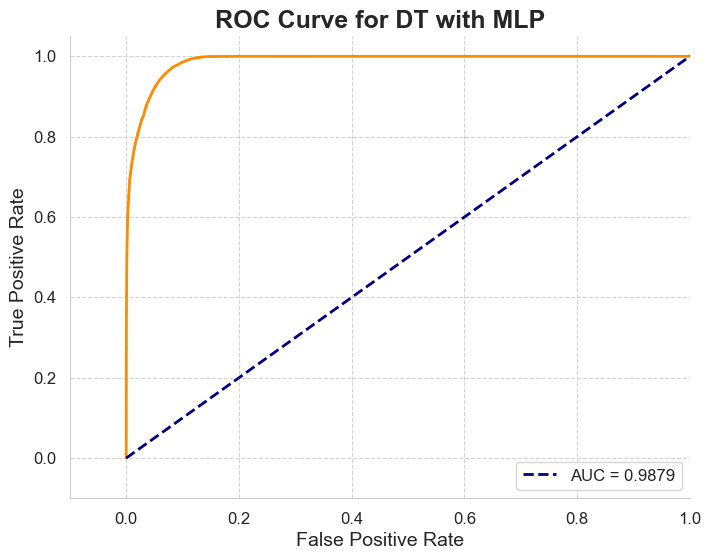

In [ ]:
roc_png(proba =y_preds_a,y=y_test_sm, name = 'ROC Curve for DT with MLP')

**hybrid MLP & Optimal DT results:**
- Test Accuracy = 95.807%.
- Test F1-score = 95.737%.
- Test Precision = 95.880%.

## hybrid DRNN with Optimal DT 2.2
split = 40% for DT and 60% for DRNN

In [ ]:
y_rnn = probas_rnn[:,1]
y_dt = probas_ada[:,1]

y_preds_Dt_rnn = (y_rnn * .6) + (y_dt* .4)

In [ ]:
y_preds_rnn_dt = (y_preds_Dt_rnn > .5 ).astype(int)
model_val(y_test_sm, y_preds_rnn_dt,y_preds_Dt_rnn)

AUC 0.9956017054306288
the recall for this model is : 0.9990192873488069
TP 55008
TN 41528
FP 2984
FN 54

----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0    0.99870   0.93296   0.96471     44512
           1    0.94854   0.99902   0.97313     55062

    accuracy                        0.96949     99574
   macro avg    0.97362   0.96599   0.96892     99574
weighted avg    0.97097   0.96949   0.96937     99574

                   pre       rec       spe        f1       geo       iba       sup

          0    0.99870   0.93296   0.99902   0.96471   0.96543   0.92589     44512
          1    0.94854   0.99902   0.93296   0.97313   0.96543   0.93820     55062

avg / total    0.97097   0.96949   0.96249   0.96937   0.96543   0.93270     99574



**hybrid DRNN & Optimal DT results:**
- Test Accuracy = 96.949%.
- Test F1-score = 96.892%.
- Test Precision = 97.370%.

## hybrid Random Forest with XGB 2.3

split = 60% xgb and 30% for DRNN
### balanced

In [73]:
y_xgb = probas_xg[:,1]
y_rf = rf_pred_proba2[:,1]

y_pred_rf_xgb = (y_xgb * .6) + (y_rf* .3)
y_preds_rf_xgb = (y_pred_rf_xgb > .5 ).astype(int)
model_val(y_test_sm, y_preds_rf_xgb,y_pred_rf_xgb)

AUC 0.9963571928367476
the recall for this model is : 0.9843449202716937
TP 54200
TN 42494
FP 2018
FN 862

----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0    0.98012   0.95466   0.96722     44512
           1    0.96410   0.98434   0.97412     55062

    accuracy                        0.97108     99574
   macro avg    0.97211   0.96950   0.97067     99574
weighted avg    0.97126   0.97108   0.97104     99574

                   pre       rec       spe        f1       geo       iba       sup

          0    0.98012   0.95466   0.98434   0.96722   0.96939   0.93693     44512
          1    0.96410   0.98434   0.95466   0.97412   0.96939   0.94251     55062

avg / total    0.97126   0.97108   0.96793   0.97104   0.96939   0.94001     99574



### unbalanced

In [74]:
y_xgb_clean = probas_xg_clean[:,1]
y_rf_clean = rf_pred_proba2_clean[:,1]

y_pred_rf_xgb_clean = (y_xgb_clean * .6) + (y_rf_clean* .3)
y_preds_rf_xgb_clean = (y_pred_rf_xgb_clean > .5 ).astype(int)
model_val(y_test_clean, y_preds_rf_xgb_clean,y_pred_rf_xgb_clean)

AUC 0.9758848296994334
the recall for this model is : 0.9832370782027533
TP 54139
TN 2088
FP 874
FN 923

----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0    0.69346   0.70493   0.69915      2962
           1    0.98411   0.98324   0.98367     55062

    accuracy                        0.96903     58024
   macro avg    0.83879   0.84408   0.84141     58024
weighted avg    0.96928   0.96903   0.96915     58024

                   pre       rec       spe        f1       geo       iba       sup

          0    0.69346   0.70493   0.98324   0.69915   0.83253   0.67382      2962
          1    0.98411   0.98324   0.70493   0.98367   0.83253   0.71240     55062

avg / total    0.96928   0.96903   0.71914   0.96915   0.83253   0.71043     58024



## hybrid DRNN with XGB 2.4

split = 35% xgb and 65% for DRNN

### balanced

In [ ]:
y_xg = probas_xg[:,1]
y_rnn = probas_rnn[:,1]

y_preds_a = (y_xg  * .35) + (y_rnn* .65)

In [ ]:
y_preds_rnn_xg = (y_preds_a > .5 ).astype(int)
print(y_preds_a)
model_val(y_test_sm,y_preds_rnn_xg, y_preds_a)

[ 1.7993357   1.1106367   2.191417   ... -1.2282809  -1.8141944
 -0.24791579]
AUC 0.9979924397720303
the recall for this model is : 0.9947513711815771
TP 54773
TN 42518
FP 1994
FN 289

----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0    0.99325   0.95520   0.97385     44512
           1    0.96487   0.99475   0.97958     55062

    accuracy                        0.97707     99574
   macro avg    0.97906   0.97498   0.97672     99574
weighted avg    0.97756   0.97707   0.97702     99574

                   pre       rec       spe        f1       geo       iba       sup

          0    0.99325   0.95520   0.99475   0.97385   0.97478   0.94643     44512
          1    0.96487   0.99475   0.95520   0.97958   0.97478   0.95395     55062

avg / total    0.97756   0.97707   0.97288   0.97702   0.97478   0.95059     99574



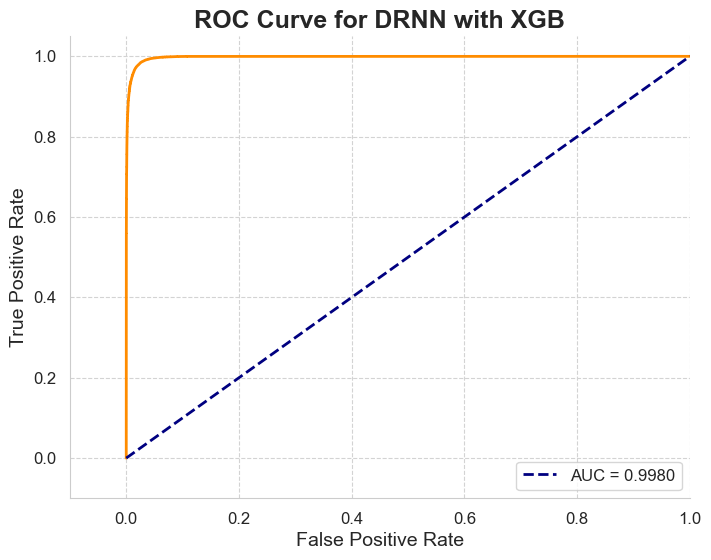

In [ ]:
roc_png(proba =y_preds_a ,y=y_test_sm, name = 'ROC Curve for DRNN with XGB' )

### unbalanced

In [ ]:
y_xg_clean = probas_xg_clean[:,1]
y_rnn_clean = probas_rnn_clean[:,1]

y_preds_a_clean = (y_xg_clean  * .35) + (y_rnn_clean* .65)

In [ ]:
y_preds_rnn_xg_clean = (y_preds_a_clean > .5 ).astype(int)
model_val(y_test_clean,y_preds_rnn_xg_clean, y_preds_a_clean)

AUC 0.9679684390398439
the recall for this model is : 0.9922814282082016
TP 54637
TN 1561
FP 1401
FN 425

----------Classification Report------------------------------------
              precision    recall  f1-score   support

         0.0    0.78600   0.52701   0.63096      2962
         1.0    0.97500   0.99228   0.98356     55062

    accuracy                        0.96853     58024
   macro avg    0.88050   0.75965   0.80726     58024
weighted avg    0.96535   0.96853   0.96556     58024

                   pre       rec       spe        f1       geo       iba       sup

        0.0    0.78600   0.52701   0.99228   0.63096   0.72315   0.49861      2962
        1.0    0.97500   0.99228   0.52701   0.98356   0.72315   0.54727     55062

avg / total    0.96535   0.96853   0.55076   0.96556   0.72315   0.54479     58024



<a id='val'></a>
## Validation

## DT & MLP

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, precision_score

# some hyper parameters
SEED = 1970
test_train_split_SEED = 1970
# FOLDS = 10
show_fold_stats = True
VERBOSE = 0
FOLDS = 10
# Lets put aside a small test set, so we can check performance of different classifiers against it
disease_train, disease_test, disease_y_train, disease_y_test =X_train_sm,X_test_sm,y_train_sm,y_test_sm
dieases_train_sc =sc_train
disease_test_sc = sc_test

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
lw = 2

mean_tpr_hybrid = 0.0
mean_fpr_hybrid = np.linspace(0, 1, 100)
lw_hybrid = 2

score_array_hybrid=[]
accuracy_array_hybrid=[]

score_array=[]
accuracy_array=[]
i = 0

skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = SEED)

for fold, (idxT,idxV) in enumerate(skf.split(disease_train, disease_y_train)):

    X_train = disease_train.iloc[idxT]
    X_val = disease_train.iloc[idxV]
    X_val_sc = dieases_train_sc[idxV]
    y_train = disease_y_train[idxT]
    y_val = disease_y_train[idxV]

    X_train_sc = dieases_train_sc[idxT]


    clf  = BalancedBaggingClassifier(
    AdaBoostClassifier(DecisionTreeClassifier(ccp_alpha =3.49297098164335e-04 , random_state=1),
                           random_state=1,n_estimators=120), n_jobs=-1)
    clf.fit(X_train, y_train)

    RF_pred_class = clf.predict(X_val)
    RF_preds = clf.predict_proba(X_val)

    RF_AUC_test_score = roc_auc_score(y_val, RF_preds[:,1])
    RF_f1_test = f1_score(y_val, RF_pred_class)
    RF_recall_test = recall_score(y_val, RF_pred_class)
    RF_precision_test = precision_score(y_val, RF_pred_class)
    RF_accuracy_score_test  = accuracy_score(y_val,RF_pred_class)
    if show_fold_stats:
        print('-' * 80)
        print('Fold : %s'%(fold+1))
        print('TRAIN ROC AUC score for DT model, validation set: %.4f'%RF_AUC_test_score)
        print('F1 : %.4f, Recall : %.4f , Precision : %.4f , Accuracy : %.4f'%(RF_f1_test, RF_recall_test, RF_precision_test,RF_accuracy_score_test))
        print(confusion_matrix(y_val, RF_pred_class))
        print("\n----------Classification Report------------------------------------")
        print(classification_report(y_val,RF_pred_class, digits=5))
        print('-'*90)

    XGB_model = BalancedBaggingClassifier(
    MLPClassifier(solver='adam', activation= 'relu', hidden_layer_sizes=120, learning_rate_init=0.0015 ), n_jobs=-1)

    XGB_model.fit(X_train_sc, y_train)

    XGB_preds = XGB_model.predict_proba(X_val_sc)
    XGB_class = XGB_model.predict(X_val_sc)

    XGB_score = roc_auc_score(y_val, XGB_preds[:,1])
    XGB_f1 = f1_score(y_val, XGB_class)
    XGB_recall = recall_score(y_val, XGB_class)
    XGB_precision = precision_score(y_val, XGB_class)
    XGB_accuracy_score_test  = accuracy_score(y_val,XGB_class)


    if show_fold_stats:
        print('TRAIN ROC AUC score for MLP model, validation set: %.4f'%XGB_score)
        print('F1 : %.4f, Recall : %.4f , Precision : %.4f ,  Accuracy : %.4f  '%(XGB_f1, XGB_recall, XGB_precision,XGB_accuracy_score_test))
        print(confusion_matrix(y_val, XGB_class))
        print("\n----------Classification Report------------------------------------")
        print(classification_report(y_val,XGB_class, digits=5))
        print('-'*90)

    RF_preds_test = clf.predict_proba(disease_test)
    XGB_preds_test = XGB_model.predict_proba(disease_test_sc)
    XGB_class_test = XGB_model.predict(disease_test_sc)
    RF_class_test = clf.predict(disease_test)
    y_mlp = XGB_preds_test[:,1]
    y_dt = RF_preds_test[:,1]

    print("-"*45,"mlp test ","-"*45)
    print('F1 : %.4f, Recall : %.4f , Precision : %.4f ,  Accuracy : %.4f '%(f1_score(disease_y_test, XGB_class_test), recall_score(disease_y_test, XGB_class_test), precision_score(disease_y_test, XGB_class_test),accuracy_score(disease_y_test,XGB_class_test)))
    print(confusion_matrix(disease_y_test,  XGB_class_test))
    print("\n----------Classification Report------------------------------------")
    print(classification_report(disease_y_test, XGB_class_test, digits=5))
    print('-'*90)


    print("-"*45,"dt test ","-"*45)
    print('F1 : %.4f, Recall : %.4f , Precision : %.4f ,  Accuracy : %.4f '%(f1_score(disease_y_test, RF_class_test), recall_score(disease_y_test, RF_class_test), precision_score(disease_y_test, RF_class_test),accuracy_score(disease_y_test,RF_class_test)))
    print(confusion_matrix(disease_y_test, RF_class_test))
    print("\n----------Classification Report------------------------------------")
    print(classification_report(disease_y_test,RF_class_test, digits=5))
    print('-'*90)


    avg_preds_test = (y_mlp * .2) + (y_dt* .8)
    print("-"*45,"hybrid","-"*45)
    RF_test_AUC = roc_auc_score(disease_y_test, RF_preds_test[:,1])
    print('ROC AUC score for DT for test set: %.4f'%RF_test_AUC)
    XGB_test_AUC = roc_auc_score(disease_y_test, XGB_preds_test[:,1])
    print('ROC AUC score for MLP model test set: %.4f'%XGB_test_AUC)
    average_AUC = roc_auc_score(disease_y_test, avg_preds_test )
    print('ROC AUC score hybrid model test set: %.4f'%average_AUC)
    y_mlp_class = XGB_class_test
    y_dt_class = RF_class_test
    avg_class = (y_mlp_class * .2) + (y_dt_class* .8)
    avg_class = (avg_class > .5 ).astype(int)
    print('F1 : %.4f, Recall : %.4f , Precision : %.4f ,  Accuracy : %.4f '%(f1_score(disease_y_test, avg_class), recall_score(disease_y_test, avg_class), precision_score(disease_y_test, avg_class),accuracy_score(disease_y_test,avg_class)))
    print(confusion_matrix(disease_y_test, avg_class))
    print("\n----------Classification Report------------------------------------")
    print(classification_report(disease_y_test,avg_class, digits=5))
    print('-'*90)

--------------------------------------------------------------------------------
Fold : 1
TRAIN ROC AUC score for DT model, validation set: 0.9974
F1 : 0.9823, Recall : 0.9908 , Precision : 0.9740 , Accuracy : 0.9810
[[ 9359   291]
 [  101 10907]]

----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0    0.98932   0.96984   0.97949      9650
           1    0.97401   0.99082   0.98235     11008

    accuracy                        0.98102     20658
   macro avg    0.98167   0.98033   0.98092     20658
weighted avg    0.98117   0.98102   0.98101     20658

------------------------------------------------------------------------------------------
TRAIN ROC AUC score for MLP model, validation set: 0.9882
F1 : 0.9565, Recall : 0.9714 , Precision : 0.9420 ,  Accuracy : 0.9529  
[[ 8992   658]
 [  315 10693]]

----------Classification Report------------------------------------
              precision    recall 

## DRNN

In [ ]:
CrossValidation(model_rnn,X_train_,y_train_,10)

fit_time: 644.19995 (+/- 43.4538)
score_time: 5.90258 (+/- 0.6561)
test_accuracy: 0.97041 (+/- 0.1704)
test_precision: 0.98027 (+/- 0.1112)
test_recall: 0.97041 (+/- 0.1704)
test_f1_score: 0.96717 (+/- 0.1899)


In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, precision_score

n_splits = 10

# Initialize the K object
kf = KFold(n_splits=n_splits, shuffle=True)

# Initialize lists to store the evaluation metrics for each fold
acc_scores = []
prec_scores = []
rec_scores = []
f1_scores = []

disease_train, disease_test, disease_y_train, disease_y_test =X_train_sm,X_test_sm,y_train_sm,y_test_sm
dieases_train_sc =sc_train
disease_test_sc = sc_test
SEED = 1970

skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = SEED)
for fold, (idxT,idxV) in enumerate(skf.split(disease_train, disease_y_train)):

    X_train = disease_train.iloc[idxT]
    X_val = disease_train.iloc[idxV]
    X_train_sc = dieases_train_sc[idxT]
    X_val_sc = dieases_train_sc[idxV]
    y_train = disease_y_train[idxT]
    y_val = disease_y_train[idxV]


    # Train the model on the training set for this fold
    xg= xgb.XGBClassifier(n_estimators=110, max_depth=13,
                    learning_rate=0.2,
                    objective='binary:logitraw',
                    max_features=None,
                    verbosity  = 0,

                    # tree_method = 'gpu_hist',
                    use_label_encoder=False,
                    n_jobs=-1,
                   random_state  = 0 )

    xg.fit(X_train,y_train)
    probas_xg=xg.predict_proba(X_val)

    Drnn = BalancedBaggingClassifier(
    MLPClassifier(solver='adam', activation= 'relu', hidden_layer_sizes=120, learning_rate_init=0.0015 ), n_jobs=-1)

    Drnn.fit(X_train_sc, y_train)
    probas_rnn = Drnn.predict_proba(X_val_sc)
    y_xgb = probas_xg[:,1]
    y_drnn = probas_rnn[:,1]

    y_preds_hy = (y_xgb  * .35) + (y_drnn* .65)
    y_preds_drnn_xgb = (y_preds_hy > .5 ).astype(int)

    y_pred = y_preds_drnn_xgb
    y_true = y_val

    # Calculate the evaluation metrics for this fold
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, average='macro')
    rec = recall_score(y_val, y_pred, average='macro')
    f1 = f1_score(y_val, y_pred, average='macro')

    # Append the evaluation metrics to the lists
    acc_scores.append(acc)
    prec_scores.append(prec)
    rec_scores.append(rec)
    f1_scores.append(f1)

# Print the average evaluation metrics over all folds
print('Accuracy:', np.mean(acc_scores))
print('Precision:', np.mean(prec_scores))
print('Recall:', np.mean(rec_scores))
print('F1 score:', np.mean(f1_scores))

Accuracy: 0.9804330559183096
Precision: 0.9804524313748377
Recall: 0.9802408827208108
F1 score: 0.9803433864500224


In [ ]:
CrossValidation(rf,X_train,y_train,10)

fit_time: 121.98865 (+/- 28.9948)
score_time: 0.24519 (+/- 0.0370)
test_accuracy: 0.95383 (+/- 0.0624)
test_precision: 0.95526 (+/- 0.0544)
test_recall: 0.95383 (+/- 0.0624)
test_f1_score: 0.95361 (+/- 0.0638)


In [ ]:
CrossValidation(rf1,X_train,y_train,10)

fit_time: 6316.53706 (+/- 3208.1614)
score_time: 12.64109 (+/- 7.7462)
test_accuracy: 0.99350 (+/- 0.0133)
test_precision: 0.99359 (+/- 0.0128)
test_recall: 0.99350 (+/- 0.0133)
test_f1_score: 0.99350 (+/- 0.0134)


In [ ]:
CrossValidation(rf2,X_train,y_train,10)

fit_time: 797.57185 (+/- 38.3452)
score_time: 7.54442 (+/- 4.5054)
test_accuracy: 0.96351 (+/- 0.0603)
test_precision: 0.96497 (+/- 0.0526)
test_recall: 0.96351 (+/- 0.0603)
test_f1_score: 0.96332 (+/- 0.0615)
